In [1]:
import pygame
import numpy as np
from time import sleep
from gymnasium import Env, spaces, register, make
import random
import os
import sys
import pandas as pd
from tqdm import tqdm, trange
import math
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
notebook_dir = os.getcwd()
images_dir = os.path.join(notebook_dir,'..','Report','images','mab')
os.makedirs(images_dir, exist_ok=True)

## 1. Create 2-armed Bernoulli bandit environment

In [3]:

class TwoArmedBernoulliBandit(Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, config=None):
        assert config is not None, f'config {config} is None'
        self.P = {
            0: { # Terminal State
                0: [(1.0, 1, 0.0, True)],
                1: [(1.0, 1, 0.0, True)]
            },
            1: {
                0: [(config['alpha'], 0, 1.0, True), (1.0 - config['alpha'], 2, 0.0, True)],
                1: [(config['beta'], 2, 1.0, True), (1.0 - config['beta'], 0, 0.0, True)]
            },
            2: { # Terminal State
                0: [(1.0, 2, 0.0, True)],
                1: [(1.0, 2, 0.0, True)]
            }
        }
        self.size = 3  # The size of the 1D grid
        self.window_size = 512  # The size of the PyGame window

        # We have 3 observations, corresponding to each position in the 1-D grid
        self.observation_space = spaces.Discrete(self.size)

        # We have 2 actions, corresponding to "left" & "right"
        self.action_space = spaces.Discrete(2)

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

        # The probability of the slip
        # self.slip_prob = slip_prob
        
        self._START_STATE = 1
        self._TERMINAL_STATES = [0, 2]

    def _get_obs(self):

        return {"agent": self._agent_location, "terminals": self._terminal_states}


    def _get_info(self):
        return {
            "distance": abs(self._agent_location - self._terminal_states[0])
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._agent_location = self._START_STATE
        self._terminal_states = self._TERMINAL_STATES

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info


    def step(self, action):

        prev_location = self._agent_location
        transitions = self.P[prev_location][action]
        probabilities, next_states, rewards, terminals = zip(*transitions)

        # Randomly select a transition based on the probabilities
        index = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        self._agent_location, reward, terminated = next_states[index], rewards[index], terminals[index]

        truncated = False
        observation = self._get_obs()
        info = self._get_info()

        info["log"] = {"current_state": prev_location,
                       "action":action,
                        "next_state": self._agent_location}

        if self.render_mode == "human":
            self._render_frame()

        # Return the required 5-tuple
        return observation, reward, terminated, truncated, info


    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):


        # The size of a single grid square in pixels
        pix_square_size = (
            self.window_size / self.size
        )

        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, pix_square_size)
            )

        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, pix_square_size))
        canvas.fill((255, 255, 255))


        # Draw both the terminal states
        pygame.draw.rect(
            canvas,
            '#EF5350',
            pygame.Rect(
                pix_square_size * np.array([self._terminal_states[0], 0]),
                (pix_square_size, pix_square_size),
            ),
        )
        
        pygame.draw.rect(
            canvas,
            '#EF5350',
            pygame.Rect(
                pix_square_size * np.array([self._terminal_states[1], 0]),
                (pix_square_size, pix_square_size),
            ),
        )

        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            '#3F51B5',
            (np.array([self._agent_location, 0]) + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [4]:
# Register the custom environment
register(id='TwoArmedBernoulliBandit-v0', entry_point=TwoArmedBernoulliBandit)

Checkout the environment in a human playing state

In [5]:
# Create and use the environment
CONFIG = {
    'alpha': 0.2,  # action_0 success probability
    'beta': 0.2,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}
environment = make('TwoArmedBernoulliBandit-v0', render_mode="human", config=CONFIG)
observation, info = environment.reset(seed=CONFIG['seed'])
for _ in range(10):
    action = environment.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = environment.step(action)

    print(info["log"])

    if terminated:
        print("Terminated", "\n\n")

    if terminated or truncated:
        observation, info = environment.reset(seed=CONFIG['seed'])
environment.close()

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 


{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 


{'current_state': 1, 'action': 0, 'next_state': 2}
Terminated 


{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 


{'current_state': 1, 'action': 0, 'next_state': 2}
Terminated 


{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 


{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 


{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 


{'current_state': 1, 'action': 0, 'next_state': 2}
Terminated 


{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 




##### 2-armed Bernoulli bandit statistics and environment checking

In [6]:
def create_env_statistics_q1(horizon=1_000_000, config=None):
    assert config is not None, 'config is None'
    # Create and use the environment
    environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=config)
    observation, info = environment.reset(seed=config['seed'])
    actions_taken = {
        0: 0,
        1: 0
    }
    action_states = {
        0: {
            0: 0,
            2: 0
        },
        1: {
            0: 0,
            2: 0
        },
    }
    for _ in range(horizon):
        action = environment.action_space.sample()  # this is where you would insert your policy
        observation, reward, terminated, truncated, info = environment.step(action)
        
        if terminated or truncated:
            actions_taken[info["log"]["action"]] += 1
            action_states[info["log"]["action"]][info["log"]["next_state"]] += 1
            
            observation, info = environment.reset(seed=config['seed'])
    environment.close()
    return actions_taken, action_states

def get_proportions(actions_taken, action_states):
    total_actions = sum(actions_taken.values())
    for action in actions_taken.keys():
        for state in action_states[action].keys():
            action_states[action][state] /= actions_taken[action]
        actions_taken[action] /= total_actions
    return actions_taken, action_states



##### $\alpha=0; \beta=0$

In [7]:
CONFIG = {
    'alpha': 0.0,  # action_0 success probability
    'beta': 0.0,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}
actions_taken, action_states = create_env_statistics_q1(1_00_000, config=CONFIG)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

actions_taken, action_states = get_proportions(actions_taken, action_states)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

Actions       
             0      1
States               
0            0  49989
2        50011      0

Actions     
             0    1
States             
0          0.0  1.0
2          1.0  0.0

##### $\alpha=1; \beta=0$

In [8]:
CONFIG = {
    'alpha': 1.0,  # action_0 success probability
    'beta': 0.0,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}
actions_taken, action_states = create_env_statistics_q1(1_00_000, config=CONFIG)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

actions_taken, action_states = get_proportions(actions_taken, action_states)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

Actions       
             0      1
States               
0        49885  50115
2            0      0

Actions     
             0    1
States             
0          1.0  1.0
2          0.0  0.0

##### $\alpha=0; \beta=1$

In [9]:
CONFIG = {
    'alpha': 0.0,  # action_0 success probability
    'beta': 1.0,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}
actions_taken, action_states = create_env_statistics_q1(1_00_000, config=CONFIG)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

actions_taken, action_states = get_proportions(actions_taken, action_states)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

Actions       
             0      1
States               
0            0      0
2        49886  50114

Actions     
             0    1
States             
0          0.0  0.0
2          1.0  1.0

##### $\alpha=1; \beta=1$

In [10]:
CONFIG = {
    'alpha': 1.0,  # action_0 success probability
    'beta': 1.0,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}
actions_taken, action_states = create_env_statistics_q1(1_00_000, config=CONFIG)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

actions_taken, action_states = get_proportions(actions_taken, action_states)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

Actions       
             0      1
States               
0        49644      0
2            0  50356

Actions     
             0    1
States             
0          1.0  0.0
2          0.0  1.0

##### $\alpha=0.5; \beta=0.5$

In [11]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}
actions_taken, action_states = create_env_statistics_q1(1_00_000, config=CONFIG)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

actions_taken, action_states = get_proportions(actions_taken, action_states)
action_states_df = pd.concat({'Actions': pd.DataFrame(action_states)}, axis=1)
action_states_df.index.name = 'States'
display(action_states_df)

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

Actions       
             0      1
States               
0        25206  25072
2        24688  25034

Actions          
               0         1
States                    
0       0.505191  0.500379
2       0.494809  0.499621

#### Environment Analysis
By the above results we can confirm that the environment is working as expected when we take random actions. From the last case where $\alpha=0.5; \beta=0.5$ We can see that any action is equally likely and we can land on any state with equal probability

----

## 2. Create 10-Armed Gaussian Bandit environment

In [12]:
class TenArmedGaussianBandit(Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None):
        self.q_star = np.random.normal(0, 1, 10)
        self.P = {
            0: {
                0: [(1.0, 0, random.gauss(self.q_star[0], sigma=1.0), True)],
                1: [(1.0, 1, random.gauss(self.q_star[1], sigma=1.0), True)],
                2: [(1.0, 2, random.gauss(self.q_star[2], sigma=1.0), True)],
                3: [(1.0, 3, random.gauss(self.q_star[3], sigma=1.0), True)],
                4: [(1.0, 4, random.gauss(self.q_star[4], sigma=1.0), True)],
                5: [(1.0, 5, random.gauss(self.q_star[5], sigma=1.0), True)],
                6: [(1.0, 6, random.gauss(self.q_star[6], sigma=1.0), True)],
                7: [(1.0, 7, random.gauss(self.q_star[7], sigma=1.0), True)],
                8: [(1.0, 8, random.gauss(self.q_star[7], sigma=1.0), True)],
                9: [(1.0, 9, random.gauss(self.q_star[9], sigma=1.0), True)],
            },
            1: {0: [(1.0, 1, 1.0, True)]},
            2: {0: [(1.0, 2, 1.0, True)]},
            3: {0: [(1.0, 3, 1.0, True)]},
            4: {0: [(1.0, 4, 1.0, True)]},
            5: {0: [(1.0, 5, 1.0, True)]},
            6: {0: [(1.0, 6, 1.0, True)]},
            7: {0: [(1.0, 7, 1.0, True)]},
            8: {0: [(1.0, 8, 1.0, True)]},
            9: {0: [(1.0, 9, 1.0, True)]}
        }
        self.size = 10  # The size of the 1D grid
        self.window_size = 512  # The size of the PyGame window

        # We have 11 observations, corresponding to each position in the 2-D grid
        self.observation_space = spaces.Discrete(self.size)

        # We have 10 actions, corresponding to each arm
        self.action_space = spaces.Discrete(10)

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

        # The probability of the slip
        # self.slip_prob = slip_prob
        
        self._START_STATE = 0
        self._TERMINAL_STATES = range(1, 10)

    def _get_obs(self):

        return {"agent": self._agent_location, "terminals": self._terminal_states}


    def _get_info(self):
        return {
            "distance": abs(self._agent_location - self._terminal_states[0])
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._agent_location = self._START_STATE
        self._terminal_states = self._TERMINAL_STATES

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info


    def step(self, action):

        prev_location = self._agent_location
        transitions = self.P[prev_location][action]
        probabilities, next_states, rewards, terminals = zip(*transitions)

        # Randomly select a transition based on the probabilities
        index = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        self._agent_location, reward, terminated = next_states[index], rewards[index], terminals[index]

        truncated = False
        observation = self._get_obs()
        info = self._get_info()

        info["log"] = {"current_state": prev_location,
                       "action":action,
                        "next_state": self._agent_location}

        if self.render_mode == "human":
            self._render_frame()

        # Return the required 5-tuple
        return observation, reward, terminated, truncated, info


    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):


        # The size of a single grid square in pixels
        pix_square_size = (
            self.window_size / self.size
        )

        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, pix_square_size)
            )

        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, pix_square_size))
        canvas.fill((255, 255, 255))


        # Draw both the terminal states
        pygame.draw.rect(
            canvas,
            '#EF5350',
            pygame.Rect(
                pix_square_size * np.array([self._terminal_states[0], 0]),
                (pix_square_size, pix_square_size),
            ),
        )
        
        pygame.draw.rect(
            canvas,
            '#EF5350',
            pygame.Rect(
                pix_square_size * np.array([self._terminal_states[1], 0]),
                (pix_square_size, pix_square_size),
            ),
        )

        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            '#3F51B5',
            (np.array([self._agent_location, 0]) + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [13]:
# Register the custom environment
register(id='TenArmedGaussianBandit-v0', entry_point=TenArmedGaussianBandit)

#### 10-armed bandit statistics and environment checking
Checking the 10-armed bandit

In [14]:
def create_env_statistics_q2(horizon=1_000, config=None):
    # Create and use the environment
    environment = make('TenArmedGaussianBandit-v0', render_mode="rgb_array")
    observation, info = environment.reset(seed=config['seed'])
    actions_taken = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0,
    }
    for _ in range(horizon):
        action = environment.action_space.sample()  # this is where you would insert your policy
        observation, reward, terminated, truncated, info = environment.step(action)
        
        if terminated or truncated:
            actions_taken[info["log"]["action"]] += 1
            
            observation, info = environment.reset(seed=config['seed'])
    environment.close()
    return actions_taken

def get_proportions(actions_taken):
    total_actions = sum(actions_taken.values())
    for action in actions_taken.keys():
        actions_taken[action] /= total_actions
    return actions_taken



In [15]:
CONFIG = {
    'seed': 21
}
actions_taken = create_env_statistics_q2(1_000, config=CONFIG)
display(actions_taken)

actions_taken_props = get_proportions(actions_taken)
display(actions_taken_props)

c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserW

{0: 103, 1: 102, 2: 94, 3: 114, 4: 88, 5: 116, 6: 93, 7: 98, 8: 105, 9: 87}

{0: 0.103,
 1: 0.102,
 2: 0.094,
 3: 0.114,
 4: 0.088,
 5: 0.116,
 6: 0.093,
 7: 0.098,
 8: 0.105,
 9: 0.087}

----------------

## 3. Bandit Agents

#### Greedy Agent

In [16]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}

environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=CONFIG)

def greedyAgent(environment, maxEpisodes):
    Q = np.zeros(environment.action_space.n)
    N = np.zeros(environment.action_space.n)
    R = np.zeros(environment.action_space.n)
    V = np.zeros(environment.observation_space.n)
    if maxEpisodes <= 1_000:
        optimal_actions = np.zeros(maxEpisodes)
        actions_taken = np.zeros(maxEpisodes)
        regret = np.zeros(maxEpisodes)
        rewards = np.zeros(maxEpisodes)
    episode_pbar = trange(maxEpisodes, bar_format="{l_bar}{bar:20}{r_bar}", desc="Greedy Agent")
    for episode in episode_pbar:
        terminated = False
        truncated = False
        observation, info = environment.reset(seed=CONFIG['seed'])
        while not (terminated or truncated):
            action = np.argmax(Q)
            observation, reward, terminated, truncated, info = environment.step(action)
            N[action] += 1
            R[action] += reward
            if maxEpisodes <= 1_000 and (terminated or truncated):
                rewards[episode] = reward
            # Q[observation["agent"]][action] = R[observation["agent"]][action] / N[observation["agent"]][action]
            Q[action] += (reward - Q[action]) / N[action]
            # episode_pbar.set_postfix({'Q': Q})
        if environment.unwrapped.spec.name == 'TwoArmedBernoulliBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(np.array([environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]]))
        elif environment.unwrapped.spec.name == 'TenArmedGaussianBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.q_star) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(environment.q_star)
        # episode_pbar.update(1)
    if maxEpisodes <= 1_000:
        return Q, rewards, regret, actions_taken, optimal_actions
    return Q

greedyAgent(environment, 1_000)

Greedy Agent:   0%|                    | 0/1000 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(
Greedy Agent: 100%|████████████████████| 1000/1000 [00:00<00:00, 10615.21it/s]


(array([0.486, 0.   ]),
 array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 

#### Pure Exploration Agent

In [17]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}

environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=CONFIG)

def pure_exploration(environment, maxEpisodes):
    Q = np.zeros(environment.action_space.n)
    N = np.zeros(environment.action_space.n)
    R = np.zeros(environment.action_space.n)
    V = np.zeros(environment.observation_space.n)
    if maxEpisodes <= 1_000:
        optimal_actions = np.zeros(maxEpisodes)
        actions_taken = np.zeros(maxEpisodes)
        regret = np.zeros(maxEpisodes)
        rewards = np.zeros(maxEpisodes)
    episode_pbar = trange(maxEpisodes, bar_format="{l_bar}{bar:20}{r_bar}", desc="Pure Exploration")
    for episode in episode_pbar:
        terminated = False
        truncated = False
        observation, info = environment.reset(seed=CONFIG['seed'])
        while not (terminated or truncated):
            action = environment.action_space.sample()
            observation, reward, terminated, truncated, info = environment.step(action)
            N[action] += 1
            R[action] += reward
            if maxEpisodes <= 1_000 and (terminated or truncated):
                rewards[episode] = reward
            # Q[observation["agent"]][action] = R[observation["agent"]][action] / N[observation["agent"]][action]
            Q[action] += (reward - Q[action]) / N[action]
            # episode_pbar.set_postfix({'Q': Q})
        if environment.unwrapped.spec.name == 'TwoArmedBernoulliBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(np.array([environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]]))
        elif environment.unwrapped.spec.name == 'TenArmedGaussianBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.q_star) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(environment.q_star)
        # episode_pbar.update(1)
    if maxEpisodes <= 1_000:
        return Q, rewards, regret, actions_taken, optimal_actions
    return Q

pure_exploration(environment, 1_000)

Pure Exploration: 100%|████████████████████| 1000/1000 [00:00<00:00, 10376.16it/s]


(array([0.53238866, 0.47826087]),
 array([0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.

#### $\epsilon$-greedy Agent

In [18]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}

environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=CONFIG)

def epsilon_greedy(environment, maxEpisodes, eps=0.1):
    Q = np.zeros(environment.action_space.n)
    N = np.zeros(environment.action_space.n)
    R = np.zeros(environment.action_space.n)
    V = np.zeros(environment.observation_space.n)
    if maxEpisodes <= 1_000:
        optimal_actions = np.zeros(maxEpisodes)
        actions_taken = np.zeros(maxEpisodes)
        regret = np.zeros(maxEpisodes)
        rewards = np.zeros(maxEpisodes)
    episode_pbar = trange(maxEpisodes, bar_format="{l_bar}{bar:20}{r_bar}", desc=f"Epsilon Greedy ({eps:.2f})")
    for episode in episode_pbar:
        terminated = False
        truncated = False
        observation, info = environment.reset(seed=CONFIG['seed'])
        while not (terminated or truncated):
            if random.random() < eps:
                action = environment.action_space.sample()
            else:    
                action = np.argmax(Q)
            observation, reward, terminated, truncated, info = environment.step(action)
            N[action] += 1
            R[action] += reward
            if maxEpisodes <= 1_000 and (terminated or truncated):
                rewards[episode] = reward
            # Q[observation["agent"]][action] = R[observation["agent"]][action] / N[observation["agent"]][action]
            Q[action] += (reward - Q[action]) / N[action]
            # episode_pbar.set_postfix({'Q': Q})
        if environment.unwrapped.spec.name == 'TwoArmedBernoulliBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(np.array([environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]]))
        elif environment.unwrapped.spec.name == 'TenArmedGaussianBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.q_star) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(environment.q_star)
        # episode_pbar.update(1)
    if maxEpisodes <= 1_000:
        return Q, rewards, regret, actions_taken, optimal_actions
    return Q

epsilon_greedy(environment, 1_000)

Epsilon Greedy (0.10): 100%|████████████████████| 1000/1000 [00:00<00:00, 9619.50it/s]


(array([0.51167728, 0.32758621]),
 array([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.

#### Decay $\epsilon$-greedy Agent

In [19]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}

environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=CONFIG)

def decay_epsilon_greedy(environment, maxEpisodes, eps=1, decay='linear', decay_rate=0.001):
    assert decay in ['linear', 'exponential'], f'decay {decay} not in ["linear", "exponential"]'
    Q = np.zeros(environment.action_space.n)
    N = np.zeros(environment.action_space.n)
    R = np.zeros(environment.action_space.n)
    V = np.zeros(environment.observation_space.n)
    if maxEpisodes <= 1_000:
        optimal_actions = np.zeros(maxEpisodes)
        actions_taken = np.zeros(maxEpisodes)
        rewards = np.zeros(maxEpisodes)
        regret = np.zeros(maxEpisodes)
    episode_pbar = trange(maxEpisodes, bar_format="{l_bar}{bar:20}{r_bar}", desc=f"Decay Epsilon Greedy ({decay}:{decay_rate})")
    
    def _decay_eps(eps, decay, decay_rate, episode):
        '''
        Decay the epsilon value
        '''
        if decay == 'linear':
            return max(0, eps - decay_rate * episode)
        if decay == 'exponential':
            return eps * math.exp(-1 * decay_rate * episode)
    
    for episode in episode_pbar:
        terminated = False
        truncated = False
        observation, info = environment.reset(seed=CONFIG['seed'])
        while not (terminated or truncated):
            current_eps = _decay_eps(eps, decay, decay_rate, episode)
            if random.random() < current_eps:
                action = environment.action_space.sample()
            else:    
                action = np.argmax(Q)
            observation, reward, terminated, truncated, info = environment.step(action)
            N[action] += 1
            R[action] += reward
            if maxEpisodes <= 1_000 and (terminated or truncated):
                rewards[episode] = reward
            # Q[observation["agent"]][action] = R[observation["agent"]][action] / N[observation["agent"]][action]
            Q[action] += (reward - Q[action]) / N[action]
            # episode_pbar.set_postfix({'Q': f'[{Q[0]:.2f} {Q[1]:.2f}]', 'eps': f'{current_eps:.5f}'})
        if environment.unwrapped.spec.name == 'TwoArmedBernoulliBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(np.array([environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]]))
        elif environment.unwrapped.spec.name == 'TenArmedGaussianBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.q_star) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(environment.q_star)
        # episode_pbar.update(1)
    if maxEpisodes <= 1_000:
        return Q, rewards, regret, actions_taken, optimal_actions
    return Q

decay_epsilon_greedy(environment, 1_000, eps=1, decay='exponential', decay_rate=0.0009)
decay_epsilon_greedy(environment, 1_000, eps=1, decay='linear', decay_rate=0.0001)

Decay Epsilon Greedy (linear:0.0001): 100%|████████████████████| 1000/1000 [00:00<00:00, 6962.11it/s]


(array([0.503861  , 0.49585062]),
 array([1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.

#### Softmax action Agent

In [20]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}

environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=CONFIG)

def softmax_action(environment, maxEpisodes, temp=1.0):
    Q = np.zeros(environment.action_space.n)
    N = np.zeros(environment.action_space.n)
    R = np.zeros(environment.action_space.n)
    V = np.zeros(environment.observation_space.n)
    if maxEpisodes <= 1_000:
        optimal_actions = np.zeros(maxEpisodes)
        actions_taken = np.zeros(maxEpisodes)
        regret = np.zeros(maxEpisodes)
        rewards = np.zeros(maxEpisodes)
    episode_pbar = trange(maxEpisodes, bar_format="{l_bar}{bar:20}{r_bar}", desc=f"Softmax Action ({temp:.2f})")
    for episode in episode_pbar:
        terminated = False
        truncated = False
        observation, info = environment.reset(seed=CONFIG['seed'])
        while not (terminated or truncated):
            probs = np.exp(Q / temp) / np.sum(np.exp(Q / temp))
            action = np.random.choice(range(environment.action_space.n), p=probs)
            observation, reward, terminated, truncated, info = environment.step(action)
            N[action] += 1
            R[action] += reward
            if maxEpisodes <= 1_000 and (terminated or truncated):
                rewards[episode] = reward
            # Q[observation["agent"]][action] = R[observation["agent"]][action] / N[observation["agent"]][action]
            Q[action] += (reward - Q[action]) / N[action]
            # episode_pbar.set_postfix({'Q': f'[{Q[0]:.2f} {Q[1]:.2f}]', 'probs': f'[{probs[0]:.2f} {probs[1]:.2f}]'})
        if environment.unwrapped.spec.name == 'TwoArmedBernoulliBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(np.array([environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]]))
        elif environment.unwrapped.spec.name == 'TenArmedGaussianBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.q_star) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(environment.q_star)
        # episode_pbar.update(1)
    if maxEpisodes <= 1_000:
        return Q, rewards, regret, actions_taken, optimal_actions
    return Q

softmax_action(environment, 1_000, temp=0.09)

Softmax Action (0.09): 100%|████████████████████| 1000/1000 [00:00<00:00, 4980.76it/s]


(array([0.48830812, 0.49084249]),
 array([0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.

#### UCB action Agent

In [21]:
CONFIG = {
    'alpha': 0.5,  # action_0 success probability
    'beta': 0.5,  # action_1 success probability
    'seed': 21,  # random seed (following an internet meme)
}

environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=CONFIG)

def ucb_action(environment, maxEpisodes, c=1.0):
    Q = np.zeros(environment.action_space.n)
    U = np.zeros(environment.action_space.n)
    N = np.zeros(environment.action_space.n)
    R = np.zeros(environment.action_space.n)
    V = np.zeros(environment.observation_space.n)
    if maxEpisodes <= 1_000:
        optimal_actions = np.zeros(maxEpisodes)
        actions_taken = np.zeros(maxEpisodes)
        regret = np.zeros(maxEpisodes)
        rewards = np.zeros(maxEpisodes)
    episode_pbar = trange(maxEpisodes, bar_format="{l_bar}{bar:20}{r_bar}", desc=f"UCB Action ({c:.2f})")
    for episode in episode_pbar:
        terminated = False
        truncated = False
        observation, info = environment.reset(seed=CONFIG['seed'])
        while not (terminated or truncated):
            if episode < len(Q):
                action = episode
            else:
                U = c * np.sqrt(np.log(episode) / N)
                action = np.argmax(Q + U)
            observation, reward, terminated, truncated, info = environment.step(action)
            N[action] += 1
            R[action] += reward
            if maxEpisodes <= 1_000 and (terminated or truncated):
                rewards[episode] = reward
            # Q[observation["agent"]][action] = R[observation["agent"]][action] / N[observation["agent"]][action]
            Q[action] += (reward - Q[action]) / N[action]
            # episode_pbar.set_postfix({'Q': f'[{Q[0]:.2f} {Q[1]:.2f}]', 'U': f'[{U[0]:.2f} {U[1]:.2f}]'})
        if environment.unwrapped.spec.name == 'TwoArmedBernoulliBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(np.array([environment.P[1][0][0][0] * environment.P[1][0][0][2], environment.P[1][1][0][0] * environment.P[1][1][0][2]]))
        elif environment.unwrapped.spec.name == 'TenArmedGaussianBandit' and maxEpisodes <= 1_000:
            V = np.max(Q)
            regret[episode] = max(environment.q_star) - V
            actions_taken[episode] = action
            optimal_actions[episode] = np.argmax(environment.q_star)
        # episode_pbar.update(1)
    if maxEpisodes <= 1_000:
        return Q, rewards, regret, actions_taken, optimal_actions
    return Q

ucb_action(environment, 1_000, c=0.2)
ucb_action(environment, 1_000, c=0.5)

UCB Action (0.50): 100%|████████████████████| 1000/1000 [00:00<00:00, 6506.97it/s]


(array([0.49481865, 0.51302932]),
 array([1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.

## 4. Running tests
- Create 50 different TwoArmedBernoulliBandit-v0 with $\alpha = \mathcal{U}(0, 1)$ and $\beta = \mathcal{U}(0, 1)$.
- Run this for 1000 episodes
- Make a reward matrix of (50, 1000) dimensions to record the reward for each episode

In [28]:
def run_tests(n_tests=2, maxEpisodes=1_000):
    reward_tensor = np.zeros((n_tests, 6, maxEpisodes))
    regret_tensor = np.zeros((n_tests, 6, maxEpisodes))
    optimal_actions_tensor = np.zeros((n_tests, 6, maxEpisodes))
    actions_taken_tensor = np.zeros((n_tests, 6, maxEpisodes))
    test_pbar = trange(n_tests, bar_format="{l_bar}{bar:20}{r_bar}")
    for test in test_pbar:
        config = {
            'alpha': random.uniform(0, 1),  # action_0 success probability
            'beta': random.uniform(0, 1),  # action_1 success probability
            'seed': 21,  # random seed (following an internet meme)
            
            'eps': 1,
            
            'eps-decay': 1,
            'eps-decay-strategy': 'exponential',
            'eps-decay-rate': 0.0009,
            
            'softmax-temp': 0.09,
            'ucb-c': 0.1
        }
        test_pbar.set_postfix({'alpha': config['alpha'], 'beta': config['beta']})
        environment = make('TwoArmedBernoulliBandit-v0', render_mode="rgb_array", config=config)
        
        _, reward_tensor[test, 0, :], regret_tensor[test, 0, :], actions_taken_tensor[test, 0, :], optimal_actions_tensor[test, 0, :] = greedyAgent(environment, maxEpisodes)
        _, reward_tensor[test, 1, :], regret_tensor[test, 1, :], actions_taken_tensor[test, 1, :], optimal_actions_tensor[test, 1, :] = pure_exploration(environment, maxEpisodes)
        _, reward_tensor[test, 2, :], regret_tensor[test, 2, :], actions_taken_tensor[test, 2, :], optimal_actions_tensor[test, 2, :] = epsilon_greedy(environment, maxEpisodes, eps=config['eps'])
        _, reward_tensor[test, 3, :], regret_tensor[test, 3, :], actions_taken_tensor[test, 3, :], optimal_actions_tensor[test, 3, :] = decay_epsilon_greedy(environment, maxEpisodes, eps=config['eps-decay'], decay=config['eps-decay-strategy'], decay_rate=config['eps-decay-rate'])
        _, reward_tensor[test, 4, :], regret_tensor[test, 4, :], actions_taken_tensor[test, 4, :], optimal_actions_tensor[test, 4, :] = softmax_action(environment, maxEpisodes, temp=config['softmax-temp'])
        _, reward_tensor[test, 5, :], regret_tensor[test, 5, :], actions_taken_tensor[test, 5, :], optimal_actions_tensor[test, 5, :] = ucb_action(environment, maxEpisodes, c=config['ucb-c'])
    return reward_tensor, regret_tensor, actions_taken_tensor, optimal_actions_tensor

reward_tensor, regret_tensor, actions_taken_tensor, optimal_actions_tensor = run_tests(n_tests=50, maxEpisodes=1_000)
reward_tensor.shape, regret_tensor.shape, actions_taken_tensor.shape, optimal_actions_tensor.shape

  0%|                    | 0/50 [00:00<?, ?it/s, alpha=0.819, beta=0.422]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_

((50, 6, 1000), (50, 6, 1000), (50, 6, 1000), (50, 6, 1000))

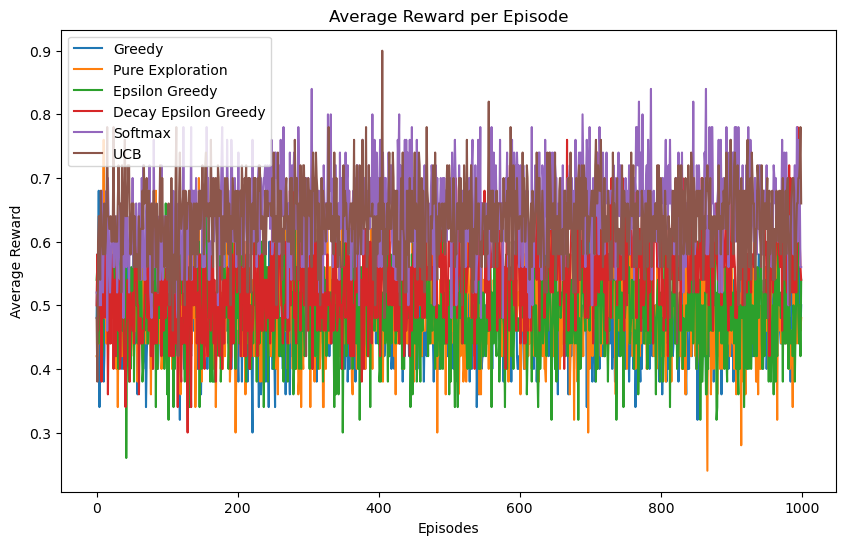

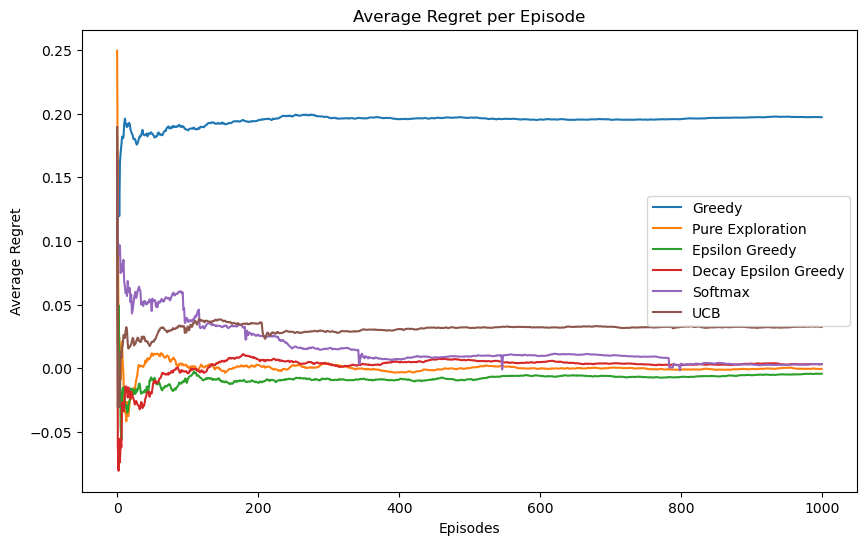

In [29]:
def plot_test_rewards(reward_tensor, image_name, maxEpisodes=1_000):
    avg_rewards = np.mean(reward_tensor, axis=0)
    fig= plt.figure(figsize=(10, 6))
    # TODO: try and change the opacity for each line in the below graph
    plt.plot(np.arange(maxEpisodes), avg_rewards[0], label='Greedy')
    plt.plot(np.arange(maxEpisodes), avg_rewards[1], label='Pure Exploration')
    plt.plot(np.arange(maxEpisodes), avg_rewards[2], label='Epsilon Greedy')
    plt.plot(np.arange(maxEpisodes), avg_rewards[3], label='Decay Epsilon Greedy')
    plt.plot(np.arange(maxEpisodes), avg_rewards[4], label='Softmax')
    plt.plot(np.arange(maxEpisodes), avg_rewards[5], label='UCB')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode')
    plt.legend()
    plt.savefig(os.path.join(images_dir, image_name))
def plot_test_regrets(regret_tensor, image_name, maxEpisodes=1_000):
    fig= plt.figure(figsize=(10, 6))
    avg_regrets = np.mean(regret_tensor, axis=0)
    plt.plot(np.arange(maxEpisodes), avg_regrets[0], label='Greedy')
    plt.plot(np.arange(maxEpisodes), avg_regrets[1], label='Pure Exploration')
    plt.plot(np.arange(maxEpisodes), avg_regrets[2], label='Epsilon Greedy')
    plt.plot(np.arange(maxEpisodes), avg_regrets[3], label='Decay Epsilon Greedy')
    plt.plot(np.arange(maxEpisodes), avg_regrets[4], label='Softmax')
    plt.plot(np.arange(maxEpisodes), avg_regrets[5], label='UCB')
    plt.xlabel('Episodes')
    plt.ylabel('Average Regret')
    plt.title('Average Regret per Episode')
    plt.legend()
    plt.savefig(os.path.join(images_dir, image_name))
plot_test_rewards(reward_tensor, image_name='bernoulli_average_reward_per_episode.pdf', maxEpisodes=1_000)
plot_test_regrets(regret_tensor, image_name='bernoulli_average_regret_per_episode.pdf', maxEpisodes=1_000)
# np.mean(reward_tensor, axis=0)

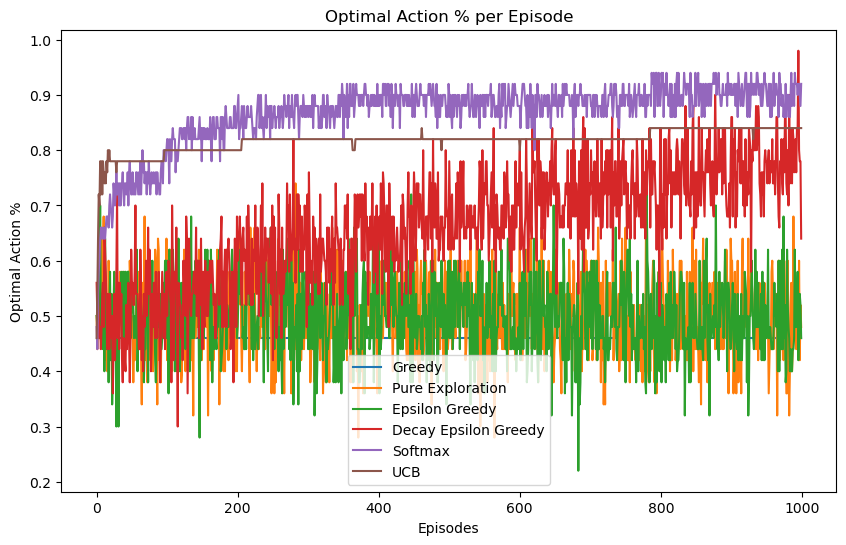

In [30]:
def plot_optimal_action_percentage(optimal_actions_tensor, actions_taken_tensor, image_name, maxEpisodes=1_000):
    optimal_action_percent = (optimal_actions_tensor == actions_taken_tensor).mean(axis=0)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.arange(maxEpisodes), optimal_action_percent[0], label='Greedy')
    ax.plot(np.arange(maxEpisodes), optimal_action_percent[1], label='Pure Exploration')
    ax.plot(np.arange(maxEpisodes), optimal_action_percent[2], label='Epsilon Greedy')
    ax.plot(np.arange(maxEpisodes), optimal_action_percent[3], label='Decay Epsilon Greedy')
    ax.plot(np.arange(maxEpisodes), optimal_action_percent[4], label='Softmax')
    ax.plot(np.arange(maxEpisodes), optimal_action_percent[5], label='UCB')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Optimal Action %')
    ax.set_title('Optimal Action % per Episode')
    ax.legend()
    plt.savefig(os.path.join(images_dir, image_name))
plot_optimal_action_percentage(optimal_actions_tensor, actions_taken_tensor, image_name='bernoulli_optimal_actions_percentage_per_episode.pdf', maxEpisodes=1_000)

## 5. Running tests for 10-Armed bandit

In [31]:
def run_tests(n_tests=2, maxEpisodes=1_000):
    reward_tensor = np.zeros((n_tests, 6, maxEpisodes))
    regret_tensor = np.zeros((n_tests, 6, maxEpisodes))
    optimal_actions_tensor = np.zeros((n_tests, 6, maxEpisodes))
    actions_taken_tensor = np.zeros((n_tests, 6, maxEpisodes))
    test_pbar = trange(n_tests, bar_format="{l_bar}{bar:20}{r_bar}", desc='10-armed bandit tests')
    for test in test_pbar:
        config = {
            'seed': 21,  # random seed (following an internet meme)
            
            'eps': 1,
            
            'eps-decay': 1,
            'eps-decay-strategy': 'exponential',
            'eps-decay-rate': 0.0009,
            
            'softmax-temp': 0.09,
            'ucb-c': 0.1
        }
        environment = make('TenArmedGaussianBandit-v0', render_mode="rgb_array")
        
        _, reward_tensor[test, 0, :], regret_tensor[test, 0, :], actions_taken_tensor[test, 0, :], optimal_actions_tensor[test, 0, :] = greedyAgent(environment, maxEpisodes)
        _, reward_tensor[test, 1, :], regret_tensor[test, 1, :], actions_taken_tensor[test, 1, :], optimal_actions_tensor[test, 1, :] = pure_exploration(environment, maxEpisodes)
        _, reward_tensor[test, 2, :], regret_tensor[test, 2, :], actions_taken_tensor[test, 2, :], optimal_actions_tensor[test, 2, :] = epsilon_greedy(environment, maxEpisodes, eps=config['eps'])
        _, reward_tensor[test, 3, :], regret_tensor[test, 3, :], actions_taken_tensor[test, 3, :], optimal_actions_tensor[test, 3, :] = decay_epsilon_greedy(environment, maxEpisodes, eps=config['eps-decay'], decay=config['eps-decay-strategy'], decay_rate=config['eps-decay-rate'])
        _, reward_tensor[test, 4, :], regret_tensor[test, 4, :], actions_taken_tensor[test, 4, :], optimal_actions_tensor[test, 4, :] = softmax_action(environment, maxEpisodes, temp=config['softmax-temp'])
        _, reward_tensor[test, 5, :], regret_tensor[test, 5, :], actions_taken_tensor[test, 5, :], optimal_actions_tensor[test, 5, :] = ucb_action(environment, maxEpisodes, c=config['ucb-c'])
    return reward_tensor, regret_tensor, actions_taken_tensor, optimal_actions_tensor

reward_tensor, regret_tensor, actions_taken_tensor, optimal_actions_tensor = run_tests(n_tests=50, maxEpisodes=1_000)
reward_tensor.shape, actions_taken_tensor.shape, optimal_actions_tensor.shape

10-armed bandit tests:   0%|                    | 0/50 [00:00<?, ?it/s]c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\divya\anaconda3\envs\pytorch_cuda_py

((50, 6, 1000), (50, 6, 1000), (50, 6, 1000))

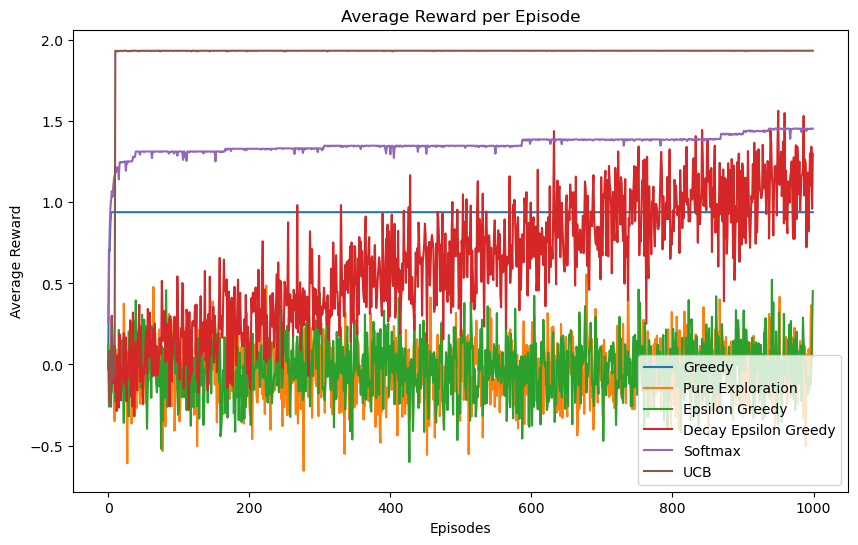

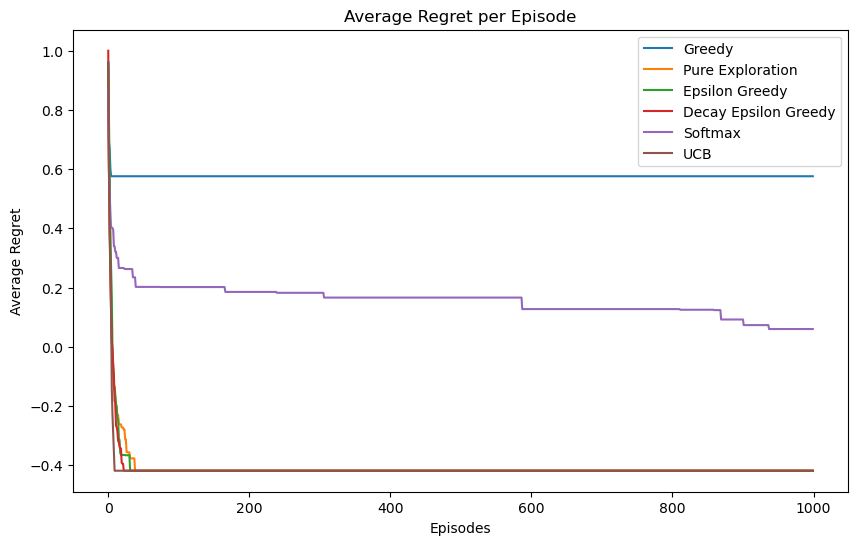

In [32]:
plot_test_rewards(reward_tensor, image_name='10_arm_gaussian_average_reward_per_episode.pdf', maxEpisodes=1_000)
plot_test_regrets(regret_tensor, image_name='10_arm_gaussian_average_regret_per_episode.pdf', maxEpisodes=1_000)
# np.mean(reward_tensor, axis=0)

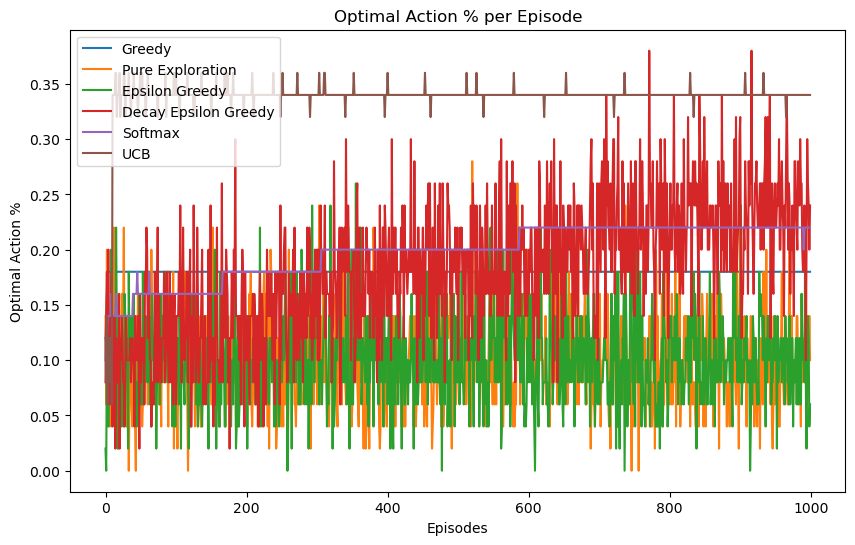

In [34]:
plot_optimal_action_percentage(optimal_actions_tensor, actions_taken_tensor, image_name='10_arm_gaussian_optimal_actions_percentage_per_episode.pdf', maxEpisodes=1_000)